# Project 3: Reddit Web APIs & NLP Classification

## Problem statement
As part of the marketing and research team for a series of Popular Science/ History books, my current goal is to increase the **science** book sales and online readership. In order to do that, i have to find out the type of science questions that people ask.  Reddit has a good repository of questions that users ask on r/askscience. However, due to a server error the web scraping from r/askscience got mixed up with the data from r/askhistorians as well!

Thankfully i happen to be a part time data scientiest as well. What i would need to do is to build two classification models in order to help differentiate the subreddits:
- 1 Naive Bayes Classifier
- 1 Support Vector Machine Classifier
- Evaluate the models based on:
    - accuracy (% predictions the model gets correct, both askscience and askhistorians)
    - precision (% predicted askscience when it is actually askscience)
    - sensitivity (% predicted askscience out of all correct predictions)
- choose the best performing model to test it on the holdout csv

## Executive Summary

Web scraping was done on subreddits r/askscience and r/askhistorians with a training dataset of 1453. Preliminary findings show that questions submitted to AskScience orbit around the **How's** while AskHistorians seek the **Why's** and **Would's**.

The best classification model was show to be a TfidfVectorizer into Naive Bayes with an accuracy score of 0.94.

## Contents
- [Web scraping and API](#Web-scraping-and-API)
- [Classification notebook](#Classification-notebook)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Pre-Processing](#Pre-Processing)
- [Classifier 1: Naive Bayes](#Classifier-1:-Naive-Bayes)
- [Classifier 2: Support Vector Machines](#Classifier-2:-Support-Vector-Machines)
- [Evaluation of models](#Evaluation-of-models)

## Web scraping and API
The web scrapping process can be found in the other [jupyter notebook here](./Project_3_webscraping.ipynb)

## Classification notebook
The two subreddits chosen for web scraping and classification are:
- [Ask Historians](https://www.reddit.com/r/AskHistorians/)
    - A subreddit that allows users to post discussions or questions on any topic regarding history.
    - The subreddit has an active user base of 1.2Million redditors.
 
    
    
- [Ask Science](https://www.reddit.com/r/askscience/)
    - Another subreddit that allows users to ask a science question and get a science answer. 
    - The subreddit is validated by an informal panel of redditors who are scientists or traing to be. 
    - Panelists chosen would have a graduate level baseline of understanding in their specialised field.
    - The subreddit has a member count of 19Million.
    
    
Both subreddits have similar types of posts by reddit users:
- Self posts (questions submitted by users)
- Mod posts (regarding the state of the subreddit)
- Bot posts (recurring weekly or daily posts)
- Ask Me Anything posts (invited named scientist/ historians to have an open discuss) 
    

In [131]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Importing visualisation libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# NLP libraries
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Classifier libraries
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
df_askh = pd.read_csv('../datasets/askhistorians.csv')
df_asksc = pd.read_csv('../datasets/askscience.csv')

In [3]:
print(df_askh.shape)
print(df_asksc.shape)

(977, 108)
(977, 104)


In [4]:
df_askh.head(10)

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,event_start,collections,event_end,event_is_live,author_cakeday
0,0,NaN,AskHistorians,"[Previous](/r/AskHistorians/search?q=title%3A""...",t2_6l4z3,False,NaN,0,False,Sunday Digest | Interesting &amp; Overlooked P...,...,1161887,1.589120e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
1,1,NaN,AskHistorians,**[Episode 147 is finally posted!](http://askh...,t2_j83ki,False,NaN,0,False,"AskHistorians Podcast Episode 147 – ""Sophonisb...",...,1161887,1.589045e+09,1,NaN,False,NaN,NaN,NaN,NaN,NaN
2,2,NaN,AskHistorians,"I'm not entirely sure if it's relevant, but th...",t2_69q5lxji,False,NaN,1,False,"In the sitcom Married... with Children, protag...",...,1161887,1.589063e+09,3,NaN,False,NaN,NaN,NaN,NaN,NaN
3,3,NaN,AskHistorians,"In Scotland, between 1406 to 1588, out of 7 mo...",t2_mwb4h,False,NaN,0,False,Why did late Medieval Scottish politics seem t...,...,1161887,1.589110e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
4,4,NaN,AskHistorians,NaN,t2_57d016ae,False,NaN,1,False,How did butlers and staff keep candle chandeli...,...,1161887,1.588997e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
5,5,NaN,AskHistorians,Did wealthy romans take beach vacations or enj...,t2_pvuu8,False,NaN,0,False,"During Roman times, would beaches have been us...",...,1161887,1.589084e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
6,6,NaN,AskHistorians,I understand Benjamin Franklin wasn't exactly ...,t2_w1ymb,False,NaN,0,False,Benjamin Franklin and the Puritans often expre...,...,1161887,1.589060e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
7,7,NaN,AskHistorians,"In The Last Kingdom, characters are shown freq...",t2_r0sgb9j,False,NaN,0,False,How would an Anglo-Saxon have navigated betwee...,...,1161887,1.589113e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
8,8,NaN,AskHistorians,So I'm a high school student and I'm very in...,t2_6d9r2vyv,False,NaN,0,False,"How Big of an Issue is Learning from ""Pop Hist...",...,1161887,1.589107e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
9,9,NaN,AskHistorians,We hear a lot of suggestions for things to cha...,t2_9v6a6,False,NaN,0,False,Rules Roundtable XI: [Answered] Answered Flair...,...,1161887,1.589116e+09,0,NaN,False,1.589116e+09,[{'permalink': 'https://www.reddit.com/r/AskHi...,1.589130e+09,True,NaN


In [5]:
df_asksc.head(10)

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
0,0,NaN,askscience,Hello everyone! We thought it was time for a m...,t2_ec1ey,False,NaN,0,False,AskScience Meta Thread: COVID-19 and reaching ...,...,/r/askscience/comments/fjt707/askscience_meta_...,all_ads,True,https://www.reddit.com/r/askscience/comments/f...,19033066,1.584396e+09,3,NaN,False,NaN
1,1,NaN,askscience,Hi! I'm Jane McGonigal. I'm the Director of Ga...,t2_ec1ey,False,NaN,0,False,"AskScience AMA Series: I'm Jane McGonigal, PhD...",...,/r/askscience/comments/gehw61/askscience_ama_s...,all_ads,True,https://www.reddit.com/r/askscience/comments/g...,19033066,1.588763e+09,1,NaN,False,NaN
2,2,NaN,askscience,Given the hilarious quarantine haircut picture...,t2_415t7,False,NaN,0,False,When in human history did we start cutting our...,...,/r/askscience/comments/gh2c1d/when_in_human_hi...,all_ads,False,https://www.reddit.com/r/askscience/comments/g...,19033066,1.589120e+09,1,NaN,False,NaN
3,3,NaN,askscience,why high-speed wind feels colder?,t2_5ypj974m,False,NaN,0,False,why high-speed wind feels colder?,...,/r/askscience/comments/ggf131/why_highspeed_wi...,all_ads,False,https://www.reddit.com/r/askscience/comments/g...,19033066,1.589029e+09,1,NaN,False,NaN
4,4,NaN,askscience,How fast is viral reproduction on the level a ...,t2_4ot5q,False,NaN,0,False,How long does it take a virus (such as Covid-1...,...,/r/askscience/comments/gh1g12/how_long_does_it...,all_ads,False,https://www.reddit.com/r/askscience/comments/g...,19033066,1.589117e+09,0,NaN,False,NaN
5,5,NaN,askscience,NaN,t2_rl2okn0,False,NaN,0,False,How does the body's immune system create an an...,...,/r/askscience/comments/ggy03t/how_does_the_bod...,all_ads,False,https://www.reddit.com/r/askscience/comments/g...,19033066,1.589101e+09,0,NaN,False,NaN
6,6,NaN,askscience,I'm trying to conceive of a scenario in which ...,t2_ffzmg,False,NaN,0,False,"Can 1,000 unentangled particles ever have less...",...,/r/askscience/comments/gh26f3/can_1000_unentan...,all_ads,False,https://www.reddit.com/r/askscience/comments/g...,19033066,1.589120e+09,0,NaN,False,NaN
7,7,NaN,askscience,NaN,t2_4jkggt99,False,NaN,0,False,Does icebergs ice taste sweet or salty?,...,/r/askscience/comments/gh2mj0/does_icebergs_ic...,all_ads,False,https://www.reddit.com/r/askscience/comments/g...,19033066,1.589122e+09,0,NaN,False,NaN
8,8,NaN,askscience,Let's say I turn on a radio transmitter. Using...,t2_5m3dl2ps,False,NaN,0,False,How does the quantization of a field really work?,...,/r/askscience/comments/gh25kb/how_does_the_qua...,all_ads,False,https://www.reddit.com/r/askscience/comments/g...,19033066,1.589120e+09,0,NaN,False,NaN
9,9,NaN,askscience,NaN,t2_4b83rk5h,False,NaN,0,False,Do those color blindness correcting glasses wo...,...,/r/askscience/comments/ggq27l/do_those_color_b...,all_ads,False,https://www.reddit.com/r/askscience/comments/g...,19033066,1.589066e+09,0,NaN,False,NaN


In [6]:
# selecting only the selftext and title of each dataframe
df_askh_text = df_askh[['selftext', 'title', 'subreddit']]
df_asksc_text = df_asksc[['selftext', 'title', 'subreddit']]

In [7]:
print(df_askh_text.shape)
df_asksc_text.shape

(977, 3)


(977, 3)

In [8]:
df_askh_text.head()

,selftext,title,subreddit
0,"[Previous](/r/AskHistorians/search?q=title%3A""...",Sunday Digest | Interesting &amp; Overlooked P...,AskHistorians
1,**[Episode 147 is finally posted!](http://askh...,"AskHistorians Podcast Episode 147 – ""Sophonisb...",AskHistorians
2,"I'm not entirely sure if it's relevant, but th...","In the sitcom Married... with Children, protag...",AskHistorians
3,"In Scotland, between 1406 to 1588, out of 7 mo...",Why did late Medieval Scottish politics seem t...,AskHistorians
4,NaN,How did butlers and staff keep candle chandeli...,AskHistorians


In [9]:
df_asksc_text.head()

,selftext,title,subreddit
0,Hello everyone! We thought it was time for a m...,AskScience Meta Thread: COVID-19 and reaching ...,askscience
1,Hi! I'm Jane McGonigal. I'm the Director of Ga...,"AskScience AMA Series: I'm Jane McGonigal, PhD...",askscience
2,Given the hilarious quarantine haircut picture...,When in human history did we start cutting our...,askscience
3,why high-speed wind feels colder?,why high-speed wind feels colder?,askscience
4,How fast is viral reproduction on the level a ...,How long does it take a virus (such as Covid-1...,askscience


## Data Cleaning

Data cleaning is an iterative process, evermore so when data is externally gathered. This section will be updated whenever a need for data cleaning arises.

- As we want the data to be representative of the userbase, we will remove any 'meta', 'moderator', 'ama series' or 'advertising posts'. These posts usually contain the name of the subreddit


- Additionally any identifiable text like 'AskScience' or 'AskHistorians' will be removed by adding to the stopwords.


- Combination of 'title' and 'selftext' columns

In [10]:
# Writing a function to check if the title has the word 'askhistorians'
df_askh_text['del'] = df_askh_text['title'].map(lambda row: 1 if 'AskHistorians' in row else 0)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# removing rows that contain the word askhistorians
df_askh_text= df_askh_text[df_askh_text['del'] !=1]

In [12]:
#dropping the newly made column
df_askh_text.drop(['del'], axis=1, inplace=True)

In [13]:
#dropping the first row of askhistorians as it is a meta post
df_askh_text.drop([0], axis=0, inplace=True)

In [14]:
df_askh_text.head()

,selftext,title,subreddit
2,"I'm not entirely sure if it's relevant, but th...","In the sitcom Married... with Children, protag...",AskHistorians
3,"In Scotland, between 1406 to 1588, out of 7 mo...",Why did late Medieval Scottish politics seem t...,AskHistorians
4,NaN,How did butlers and staff keep candle chandeli...,AskHistorians
5,Did wealthy romans take beach vacations or enj...,"During Roman times, would beaches have been us...",AskHistorians
6,I understand Benjamin Franklin wasn't exactly ...,Benjamin Franklin and the Puritans often expre...,AskHistorians


In [15]:
df_asksc_text['del'] = df_asksc_text['title'].map(lambda row: 1 if 'AskScience' in row else 0)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
df_asksc_text.head()

,selftext,title,subreddit,del
0,Hello everyone! We thought it was time for a m...,AskScience Meta Thread: COVID-19 and reaching ...,askscience,1
1,Hi! I'm Jane McGonigal. I'm the Director of Ga...,"AskScience AMA Series: I'm Jane McGonigal, PhD...",askscience,1
2,Given the hilarious quarantine haircut picture...,When in human history did we start cutting our...,askscience,0
3,why high-speed wind feels colder?,why high-speed wind feels colder?,askscience,0
4,How fast is viral reproduction on the level a ...,How long does it take a virus (such as Covid-1...,askscience,0


In [17]:
df_asksc_text = df_asksc_text[df_asksc_text['del']!=1]

In [18]:
df_asksc_text.drop(['del'], axis=1, inplace=True)

In [19]:
df_asksc_text.head()

,selftext,title,subreddit
2,Given the hilarious quarantine haircut picture...,When in human history did we start cutting our...,askscience
3,why high-speed wind feels colder?,why high-speed wind feels colder?,askscience
4,How fast is viral reproduction on the level a ...,How long does it take a virus (such as Covid-1...,askscience
5,NaN,How does the body's immune system create an an...,askscience
6,I'm trying to conceive of a scenario in which ...,"Can 1,000 unentangled particles ever have less...",askscience


In [20]:
#Taking only posts index 2 onwards
df_merge = pd.concat([df_askh_text, df_asksc_text])

In [21]:
#Checking the shape of the newly merged dataframe
df_merge.shape

(1938, 3)

In [22]:
#checking for null values.
df_merge.isnull().sum()

selftext     518
title          0
subreddit      0
dtype: int64

In [23]:
#Important to change values to blank as missing data overides any concatinations
df_merge.fillna('',inplace=True)

In [24]:
#Combining the title and selftext into text
df_merge['text'] = df_merge['title'] + df_merge['selftext']

In [25]:
#Checking the merger of 'text'
df_merge.head()

,selftext,title,subreddit,text
2,"I'm not entirely sure if it's relevant, but th...","In the sitcom Married... with Children, protag...",AskHistorians,"In the sitcom Married... with Children, protag..."
3,"In Scotland, between 1406 to 1588, out of 7 mo...",Why did late Medieval Scottish politics seem t...,AskHistorians,Why did late Medieval Scottish politics seem t...
4,,How did butlers and staff keep candle chandeli...,AskHistorians,How did butlers and staff keep candle chandeli...
5,Did wealthy romans take beach vacations or enj...,"During Roman times, would beaches have been us...",AskHistorians,"During Roman times, would beaches have been us..."
6,I understand Benjamin Franklin wasn't exactly ...,Benjamin Franklin and the Puritans often expre...,AskHistorians,Benjamin Franklin and the Puritans often expre...


In [26]:
#dropping the selftext and title columns
df_merge.drop(['title', 'selftext'], axis=1 ,inplace=True)

In [27]:
# Checking if the dataframe dropped the right columns
df_merge.head()

,subreddit,text
2,AskHistorians,"In the sitcom Married... with Children, protag..."
3,AskHistorians,Why did late Medieval Scottish politics seem t...
4,AskHistorians,How did butlers and staff keep candle chandeli...
5,AskHistorians,"During Roman times, would beaches have been us..."
6,AskHistorians,Benjamin Franklin and the Puritans often expre...


In [28]:
#Changing askscience to my positive outcome
df_merge['subreddit'] = df_merge['subreddit'].map(lambda row: 1 if row == 'askscience' else 0)

In [29]:
df_merge.head()

,subreddit,text
2,0,"In the sitcom Married... with Children, protag..."
3,0,Why did late Medieval Scottish politics seem t...
4,0,How did butlers and staff keep candle chandeli...
5,0,"During Roman times, would beaches have been us..."
6,0,Benjamin Franklin and the Puritans often expre...


### Cleaning holdout data

In [30]:
# Loading holdout dataset
holdout = pd.read_csv('../datasets/holdout.csv')

In [31]:
# Cleaning
holdout_df = holdout[['subreddit', 'selftext', 'title']]

In [32]:
# Checking the shape after cleaning
holdout_df.shape

(250, 3)

In [33]:
# Checking
holdout_df.head()

,subreddit,selftext,title
0,askscience,I do a lot of electrical work on cars and it’s...,"When electricity is flowing, do electrons trav..."
1,askscience,I know that our immune system can essentially ...,How many diseases can we develop immunities for?
2,askscience,Suppose someone figures out how to make 3 gra...,How would one be able to tell an antimatter ex...
3,askscience,"If not, can other waves be approximated? Such ...",Can light come in anything other than a sine w...
4,askscience,I've seen estimates of 1%-5%. Looking at the t...,How is the mortality rate for COVID-19 calcula...


In [34]:
# Checking for missing values
holdout_df.isnull().sum()

subreddit     0
selftext     71
title         0
dtype: int64

In [35]:
# Changing all missing values to blanks
holdout_df = holdout_df.fillna('')

In [36]:
# checking if the fillna worked
holdout_df.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

In [37]:
#Combining the title and selftext
holdout_df['text'] = holdout_df['title'] + holdout_df['selftext']

In [38]:
# Dropping the title and selftext
holdout_df.drop(['title', 'selftext'], axis=1 ,inplace=True)

In [39]:
#Checcking if the text column and dropped columns are done
holdout_df.head()

,subreddit,text
0,askscience,"When electricity is flowing, do electrons trav..."
1,askscience,How many diseases can we develop immunities fo...
2,askscience,How would one be able to tell an antimatter ex...
3,askscience,Can light come in anything other than a sine w...
4,askscience,How is the mortality rate for COVID-19 calcula...


In [40]:
#Changing askscience to my positive outcome
holdout_df['subreddit'] = holdout_df['subreddit'].map(lambda row: 1 if row == 'askscience' else 0)

In [41]:
# last check
holdout_df.head()

,subreddit,text
0,1,"When electricity is flowing, do electrons trav..."
1,1,How many diseases can we develop immunities fo...
2,1,How would one be able to tell an antimatter ex...
3,1,Can light come in anything other than a sine w...
4,1,How is the mortality rate for COVID-19 calcula...


## Exploratory Data Analysis

### Wordcloud

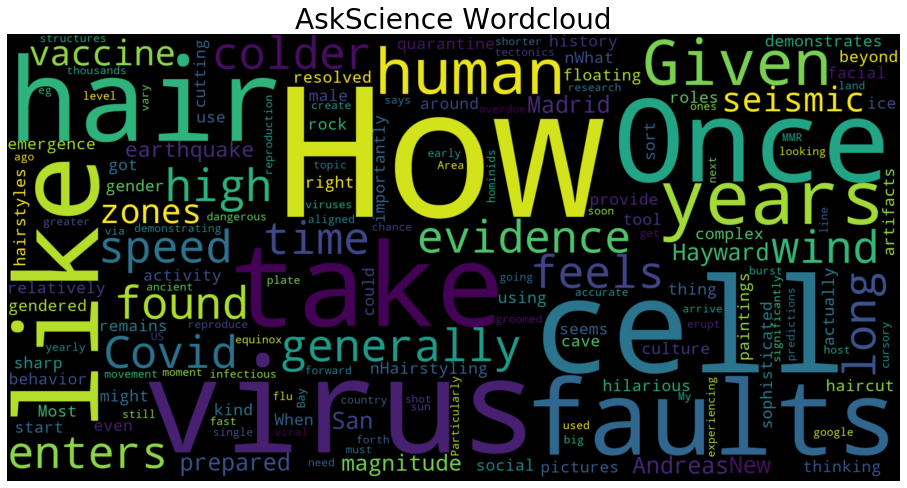

In [42]:
# Askscience wordcloud
wordcloud = WordCloud(stopwords=set(stopwords.words('english') + ['askscience','askhistorians']),
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(df_merge[df_merge['subreddit']==1].values))

plt.figure(figsize=(16,9))
plt.title('AskScience Wordcloud', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

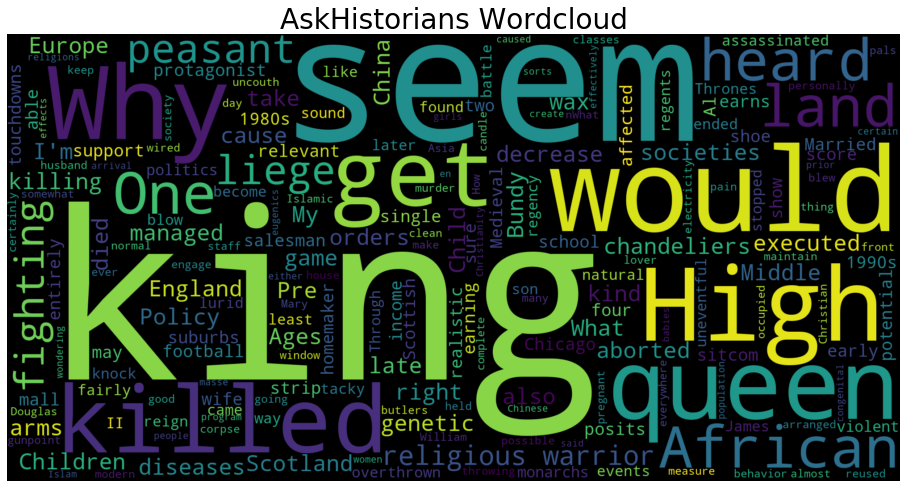

In [43]:
# AskHistorians wordcloud
wordcloud = WordCloud(stopwords=set(stopwords.words('english') + ['askscience','askhistorians']),
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(df_merge[df_merge['subreddit']==0].values))

plt.figure(figsize=(16,9))
plt.title('AskHistorians Wordcloud', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

The questions that redditors submit to askscience and askhistorians differ:
- Questions submitted to AskScience orbit around the **How's**
- Whereas AskHistorians seek the **Why's** and **Would's**

### Distribution of number of words

In [44]:
# Creating a new column to count the len of string
df_merge['string_count'] = df_merge['text'].apply(len)

# Creating a new column to count the number of words
df_merge['word_count'] = df_merge['text'].map(lambda row: len(row.split()))

In [45]:
df_merge.head()

,subreddit,text,string_count,word_count
2,0,"In the sitcom Married... with Children, protag...",464,81
3,0,Why did late Medieval Scottish politics seem t...,1116,206
4,0,How did butlers and staff keep candle chandeli...,210,35
5,0,"During Roman times, would beaches have been us...",280,43
6,0,Benjamin Franklin and the Puritans often expre...,288,45


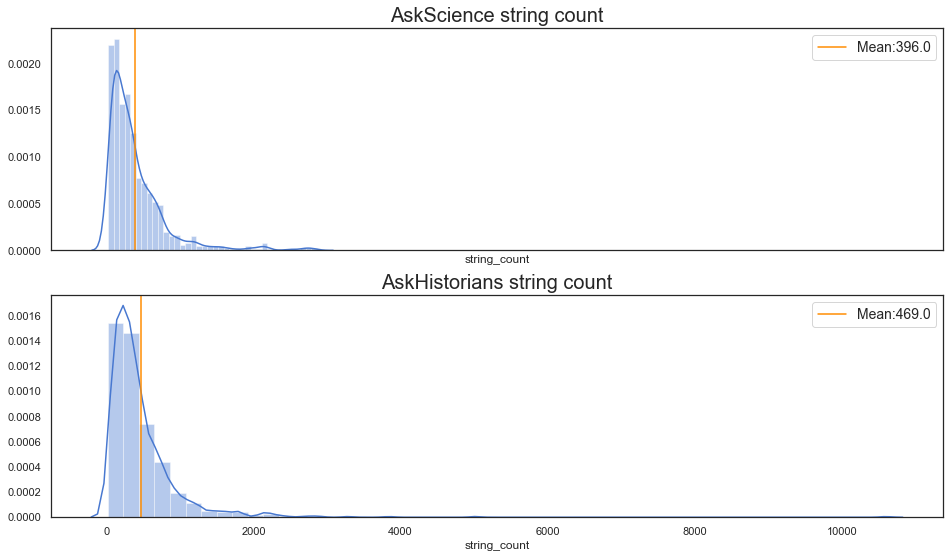

In [46]:
# Distribution of strings
asksci_str_count = df_merge[df_merge['subreddit']==1]['string_count']
askhist_str_count = df_merge[df_merge['subreddit']==0]['string_count']

sns.set(style="white", palette="muted", color_codes=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9), sharex=True)

# AskScience distplot
sns.distplot(asksci_str_count, ax=ax1).axvline(asksci_str_count.mean(), color='darkorange')
ax1.set_title('AskScience string count', fontsize=20)
ax1.legend({f'Mean:{round(asksci_str_count.mean(),0)}':asksci_str_count.mean()}, fontsize=14)

# AskHistorians distplot
sns.distplot(askhist_str_count, ax=ax2).axvline(askhist_str_count.mean(), color='darkorange')
ax2.set_title('AskHistorians string count', fontsize=20)
ax2.legend({f'Mean:{round(askhist_str_count.mean(),0)}':askhist_str_count.mean()}, fontsize=14);

Length of string is skewed to the right with a right long tail for both askscience and askhistorians. Askscience has a lower mean string count of 396 vs askhistorian's 469.

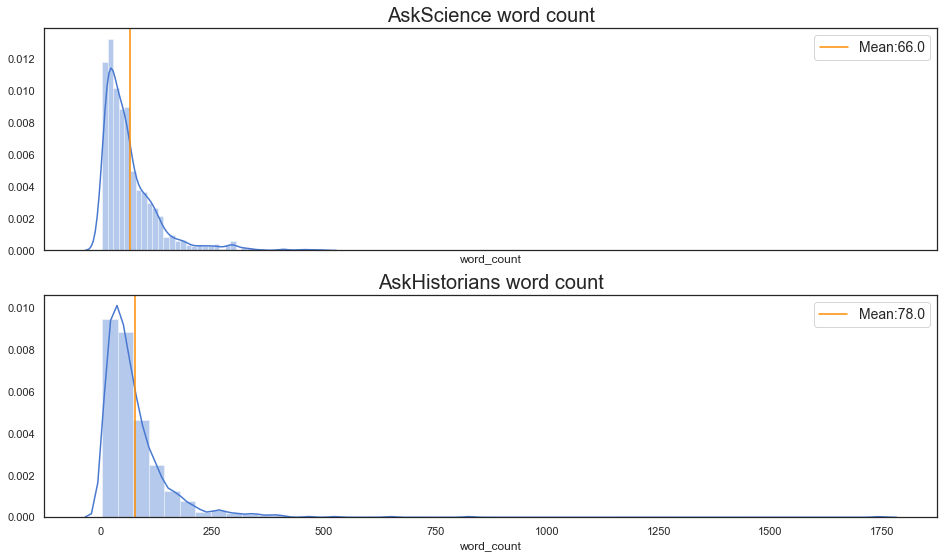

In [47]:
# Distribution of word count
asksci_word_count = df_merge[df_merge['subreddit']==1]['word_count']
askhist_word_count = df_merge[df_merge['subreddit']==0]['word_count']

sns.set(style="white", palette="muted", color_codes=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9), sharex=True)

# AskScience distplot
sns.distplot(asksci_word_count, ax=ax1).axvline(asksci_word_count.mean(), color='darkorange')
ax1.set_title('AskScience word count', fontsize=20)
ax1.legend({f'Mean:{round(asksci_word_count.mean(),0)}':asksci_word_count.mean()}, fontsize=14)

# AskHistorians distplot
sns.distplot(askhist_word_count, ax=ax2).axvline(askhist_word_count.mean(), color='darkorange')
ax2.set_title('AskHistorians word count', fontsize=20)
ax2.legend({f'Mean:{round(askhist_word_count.mean(),0)}':askhist_word_count.mean()}, fontsize=14);

Not much discernable difference in the mean or distribution of length of words and length of string. But again we see a right skew with a long right tail. Mean word count for askscience is 66 while askhistorians is at 78.

### Train test split

In [48]:
# Assigning X and y
X = df_merge[['text']]
y = df_merge['subreddit']

In [49]:
# Train test splitting my df_merge data
# Shuff
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42)

In [50]:
X_train.shape

(1453, 1)

In [51]:
X_test.shape

(485, 1)

## Pre-Processing
Lemmatizer was used instead of Stemmer as Stemmer returned many words with spelling errors

In [52]:
# Instantiating Tokenizer, PorterStemmer and lemmatizer

tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [53]:
#taken from DSI-14 week 5.03 NLP startercode
def pre_processing(raw_text):

    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_text).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Searching a set is much faster than searching a list
    #    Adding in additional stopwords.
    stops = set(stopwords.words('english') + ['askscience','askhistorians'])
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    
    #5.5 lemmatizing of words
    meaningful_words = [lemmatizer.lemmatize(w) for w in words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [54]:
# Get the number of posts on the dataframe size.
total_posts= X.shape[0]
print(f'There are {total_posts} posts')

There are 1938 posts


In [55]:
# Initialize an empty list to hold the clean posts.
clean_train_posts = []
clean_test_posts = []

print("Cleaning and parsing the training data...")

# Instantiate counter.
j = 0

# For every post in our training set...
for train_posts in X_train['text']:
    
    # Convert post to words, then append to clean_train_posts.
    clean_train_posts.append(pre_processing(train_posts))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 100 == 0:
        print(f'Post {j + 1} of {total_posts}.')
    
    j += 1

# Let's do the same for our testing set.
print("Cleaning and parsing the testing data...")

# For every review in our testing set...
for test_posts in X_test['text']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_test_posts.append(pre_processing(test_posts))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 100 == 0:
        print(f'Post {j + 1} of {total_posts}.')
        
    j += 1

Cleaning and parsing the training data...
Post 100 of 1938.
Post 200 of 1938.
Post 300 of 1938.
Post 400 of 1938.
Post 500 of 1938.
Post 600 of 1938.
Post 700 of 1938.
Post 800 of 1938.
Post 900 of 1938.
Post 1000 of 1938.
Post 1100 of 1938.
Post 1200 of 1938.
Post 1300 of 1938.
Post 1400 of 1938.
Cleaning and parsing the testing data...
Post 1500 of 1938.
Post 1600 of 1938.
Post 1700 of 1938.
Post 1800 of 1938.
Post 1900 of 1938.


In [56]:
# Checking
clean_train_posts[:1]

['what doe actually affect our eyesight reading in the dark using screen at a high brightness something else entirely this stem from a discussion i had with my father he ha his monitor permanently set to the highest brightness and a desk lamp constantly on right next to it on the other hand i always set the brightness according to what i m doing so if i m using a program with a white background i take it down to nearly but i also tend to have my curtain halfway drawn due to sun reflecting of the next building so on average my room is darker i cannot understand his method it s a terrible amount of light shining right into his face however he in turn say my contrast is too low and that damage my eye i think i ve read a headline somewhere stating that reading in the dark while tiring doe not cause permanent damage so my question is which factor can affect eyesight in the long term brightness contrast something else how should i set my monitor article link would be appreciated so i can eas

In [57]:
# Checking
clean_test_posts[:5]

['what happened to german soldier who were made disabled in combat during ww',
 'after wwi how were ex soldier suffering from ptsd treated at least according to wikipedia ptsd in soldier wa only truly investigated after the vietnam war but if modern warfare is a major cause of ptsd then surely some soldier at wwi were also developing at least some symptom of it how aware were the psychologist and physician of the time of this condition i m also interested to know whether the soldier had access to any sort of psychological treatment a well a how they were treated by society afterward were they able to have somewhat regular life after the war i assume that the answer might vary from country to country so feel free to answer about whichever one you re most familiar with',
 'when a limb is lost what happens to the brain cell that are assigned to control it',
 'why do dog have little slit on the outside of their nose when i get really close to my dog i see small slit on the side of his nose

### Preprocessing the holdout dataset

In [58]:
holdout_X = holdout_df[['text']]
holdout_y = holdout_df['subreddit']

In [59]:
# Initialize an empty list to hold the clean posts.
holdout_text = []

print("Cleaning and parsing the holdout data...")
# For every post in our training set...
for text in holdout_df['text']:
    
    # Convert post to words, then append to holdout_text
    holdout_text.append(pre_processing(text))

Cleaning and parsing the holdout data...


In [60]:
# Checking
holdout_text[:5]

['when electricity is flowing do electron travel on top of a conductor or do they penetrate and flow inside i do a lot of electrical work on car and it s common to sometimes have to scratch a small portion of metal to remove any paint or rust when trying to find a good ground source got me wondering if electron penetrate into the metal and that scratched part just act a an entry point for them to get into',
 'how many disease can we develop immunity for i know that our immune system can essentially remember certain type of disease to respond rapidly to them is there a limit to the number of disease we can develop an immunity for',
 'how would one be able to tell an antimatter explosion from a run of the mill normal nuclear detonation suppose someone figure out how to make gram of antimatter leaf it to explode how would it differ from a normal nuclear bomb what kind of radiation and how much of it would it release how would we able to tell it came from an antimatter reaction',
 'can lig

# Classifier 1: Naive Bayes

The model should aim to optimise sensitivity and precision

- Baseline: Proportion of target variable: 49.6%
- pipe1: Pipeline of Countvectorizer -> Naive Bayes
- pipe2: Pipeline of TFIDvectorizer -> Naive Bayes

In [61]:
# Baseline accuracy score using proportion
y_test.value_counts(normalize=True)

0    0.503093
1    0.496907
Name: subreddit, dtype: float64

In [62]:
# Instantiate pipeline 1 and 2
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe2 = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('nb', MultinomialNB())
])


In [63]:
# Countvectorizer->Naive Bayes hyperparameters
pipe_params1 = {
    
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.85, 0.9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha' : [0.9,1]
    
    
}

pipe_params2 =  {
    
    'tfid__max_features': [2000,3000,4000,5000],
    'tfid__min_df': [2,3],
    'tfid__max_df': [0.85, 0.9],
    'tfid__ngram_range': [(1,1), (1,2)],
    'nb__alpha' : [0.9,1]
    
}

In [64]:
#Instantiating both gridsearchCV

gs1 = GridSearchCV(pipe1, param_grid=pipe_params1, cv=5)
gs2 = GridSearchCV(pipe2, param_grid=pipe_params2, cv=5)

In [65]:
#Fitting gs1 countvectorizer->multinomial naive bayes
gs1.fit(clean_train_posts, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [66]:
#Fitting gs2 TfID-vectorizer->multinomial naive bayes
gs2.fit(clean_train_posts, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfid',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

### gs1

In [67]:
# best parameters for gs1
gs1.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 0.9}

In [68]:
# gs1 score of training data
gs1.score(clean_train_posts, y_train)

0.9896765313145217

In [69]:
# gs1 score of test data
gs1.score(clean_test_posts, y_test)

0.9525773195876288

Slight overfitting on the training data. Accuracy score is very high for both

In [70]:
# prediction of gs1 model on test data
predict_1 = gs1.predict(clean_test_posts)

In [71]:
# confusion matrix
confusion_matrix(predict_1, y_test)

array([[236,  15],
       [  8, 226]], dtype=int64)

In [72]:
tn, fp, fn, tp = confusion_matrix(predict_1, y_test).ravel()

In [73]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 236
False Positives: 15
False Negatives: 8
True Positives: 226


In [74]:
# calculating precision and sensitivty of gs1
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)

print('Precision of gs1 is: %s' % round(Precision,2))
print('Sensitivity of gs1 is: %s' % round(Sensitivity,2))

Precision of gs1 is: 0.94
Sensitivity of gs1 is: 0.97


### gs2

In [75]:
# best parameters for gs2
gs2.best_params_

{'nb__alpha': 1,
 'tfid__max_df': 0.85,
 'tfid__max_features': 4000,
 'tfid__min_df': 2,
 'tfid__ngram_range': (1, 1)}

In [76]:
# scoring gs2 on the training set
gs2.score(clean_train_posts, y_train)

0.9896765313145217

In [77]:
# scoring gs2 on the test set
gs2.score(clean_test_posts, y_test)

0.9608247422680413

Again slight overfitting but accuracy score is high on both

In [78]:
# predicitng output on test set using gs2 model
predict_2 = gs2.predict(clean_test_posts)

In [79]:
# confusion matrix of gs2
confusion_matrix(predict_2, y_test)

array([[237,  12],
       [  7, 229]], dtype=int64)

In [80]:
tn, fp, fn, tp = confusion_matrix(predict_2, y_test).ravel()

In [81]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 237
False Positives: 12
False Negatives: 7
True Positives: 229


In [82]:
# calulcating precision and sensitivity of gs2
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)

print('Precision of gs1 is: %s' % round(Precision,2))
print('Sensitivity of gs1 is: %s' % round(Sensitivity,2))

Precision of gs1 is: 0.95
Sensitivity of gs1 is: 0.97


**Manually checking the gridsearch parameters**

In [83]:
#Count vectorizing
vectorizer = CountVectorizer(max_df=0.9,
                             min_df=2,
                             max_features = 4000) 

In [84]:
train_data_features = vectorizer.fit_transform(clean_train_posts)
test_data_features = vectorizer.transform(clean_test_posts)

In [85]:
nb = MultinomialNB(alpha=0.9)
nb.fit(train_data_features, y_train)
nb.score(train_data_features, y_train)

0.9896765313145217

In [86]:
nb.score(test_data_features, y_test)

0.9525773195876288

# Classifier 2: Support Vector Machines
- Baseline: Mean of target variable: 50%
- pipe3 = CountVectorizer -> Support Vector Machines
- pipe4 = Pipeline of TFIDvectorizer -> Support Vector Machines

In [87]:
# Instantiate pipeline 3 and 4
pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('svm',SVC())
])

pipe4 = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('svm', SVC())
])


In [88]:
# Countvectorizer->Naive Bayes hyperparameters
# The initial gridsearch fitting took 9mins each.
# I will reduce the number hyperparameters to the best_params_ in order to reduce computing time

pipe_params3 = {

    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.85, 0.9],
    #ngram_range [(1,1), (1,2)]
    'cvec__ngram_range': [(1,1)],
    'svm__C' : [0.9, 1],
    # Initially ran 'rbf, 'linear', 'poly', 'sigmoid'
    'svm__kernel' : ['linear']
    
    
}

pipe_params4 =  {

    'tfid__max_features': [2000,3000,4000,5000],
    'tfid__min_df': [2,3],   
    'tfid__max_df': [0.85, 0.9],
    #ngram_range [(1,1), (1,2)]
    'tfid__ngram_range': [(1,1)],
    'svm__C' : [0.9, 1],
    # Initially ran 'rbf, 'linear', 'poly', 'sigmoid'
    'svm__kernel' : ['linear']
    
}

In [89]:
#Instantiating both gridsearchCV

gs3 = GridSearchCV(pipe3, param_grid=pipe_params3, cv=5)
gs4 = GridSearchCV(pipe4, param_grid=pipe_params4, cv=5)

In [90]:
%%time
#Fitting gs3 countvectorizer->SVM
gs3.fit(clean_train_posts, y_train)

Wall time: 2min 42s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [91]:
%%time
#Fitting gs4 TFIDvectorizer->SVM
gs4.fit(clean_train_posts, y_train)

Wall time: 2min 20s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfid',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [92]:
#best params for gs3
gs3.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'svm__C': 1,
 'svm__kernel': 'linear'}

In [93]:
#best params for gs4
gs4.best_params_

{'svm__C': 1,
 'svm__kernel': 'linear',
 'tfid__max_df': 0.85,
 'tfid__max_features': 2000,
 'tfid__min_df': 3,
 'tfid__ngram_range': (1, 1)}

### gs3

In [94]:
# scoring gs3 on the train data
# gs3 is overfitted if it has a score of 1
gs3.score(clean_train_posts, y_train)

1.0

In [95]:
# scoring gs3 on the test data
gs3.score(clean_test_posts, y_test)

0.9134020618556701

In [96]:
# prediction of test using model gs3
predict_3 = gs3.predict(clean_test_posts)

In [97]:
# confusion matrix
confusion_matrix(predict_3, y_test)

array([[228,  26],
       [ 16, 215]], dtype=int64)

In [98]:
tn, fp, fn, tp = confusion_matrix(predict_3, y_test).ravel()

In [99]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 228
False Positives: 26
False Negatives: 16
True Positives: 215


In [100]:
# calculating the precisions and sensitivity of gs3
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)

print('Precision of gs3 is: %s' % round(Precision,2))
print('Sensitivity of gs3 is: %s' % round(Sensitivity,2))

Precision of gs3 is: 0.89
Sensitivity of gs3 is: 0.93


### gs4

In [101]:
# scoring gs4 on training data
gs4.score(clean_train_posts, y_train)

0.993805918788713

In [102]:
# scoring gs4 on test data
gs4.score(clean_test_posts, y_test)

0.934020618556701

In [103]:
# predicting outcome variables using gs4
predict_4 = gs4.predict(clean_test_posts)

In [104]:
# confusion matrix
confusion_matrix(predict_4, y_test)

array([[232,  20],
       [ 12, 221]], dtype=int64)

In [105]:
tn, fp, fn, tp = confusion_matrix(predict_4, y_test).ravel()

In [106]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 232
False Positives: 20
False Negatives: 12
True Positives: 221


In [107]:
# calculating the precision and sensitivity
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)

print('Precision of gs4 is: %s' % round(Precision,2))
print('Sensitivity of gs4 is: %s' % round(Sensitivity,2))

Precision of gs4 is: 0.92
Sensitivity of gs4 is: 0.95


# Evaluation of models

CountVectorizer into Naive Bayes gives the best scores according to accuracy, precision and sensitivity. As such, i will be using it to predict on a holdout dataset.

|Model|Accuracy Score on train|Accuracy Score on test|Precision|Sensitivity|
|---|---|---|---|---|
|**gs1** CountVectorizer->Naive Bayes|0.990|0.955|0.94|0.97|
|**gs2** TfidfVectorizer->Naive Bayes|0.991|0.961|0.95|0.97|
|**gs3** CountVectorizer->Support Vector Machines|1.000|0.915|0.89|0.93|
|**gs4** TfidfVectorizer->Support Vector Machines|0.998|0.940|0.93|0.95|

In [108]:
#creating a dataframe that holds true values of the test set
# as well as the predicted probabilty

pred_proba = [i[1] for i in gs1.predict_proba(clean_test_posts)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [109]:
pred_df.head()

,true_values,pred_probs
565,0,1.740849e-08
548,0,1.143844e-23
212,1,9.997121e-01
163,1,8.263289e-01
567,0,1.156623e-17


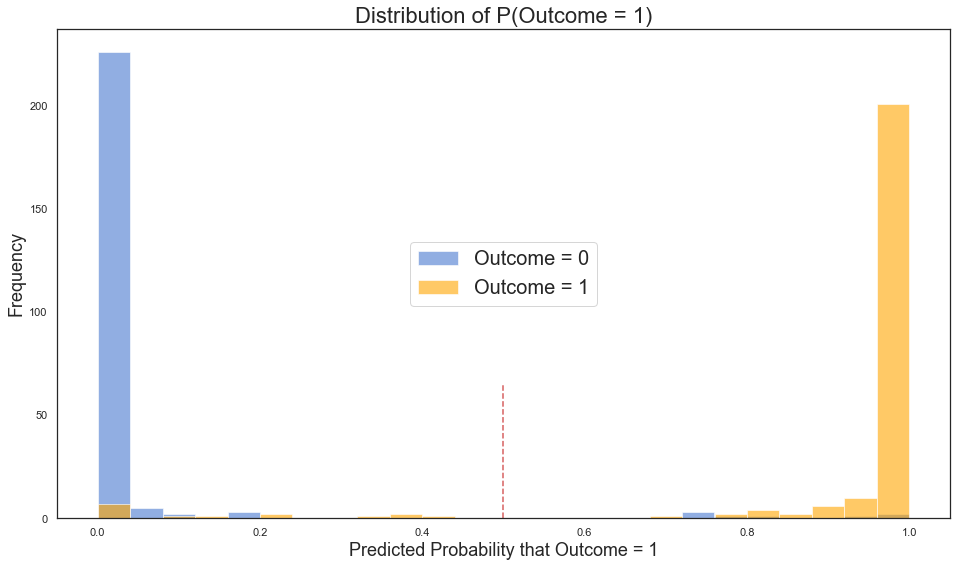

In [110]:
# Creating a histrogram of predicted probability.
plt.figure(figsize = (16,9))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')


# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20, loc='center');

In [111]:
# Calculate ROC AUC.
# This measures how distinct the askscience and askhistorians are
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9925515271069996

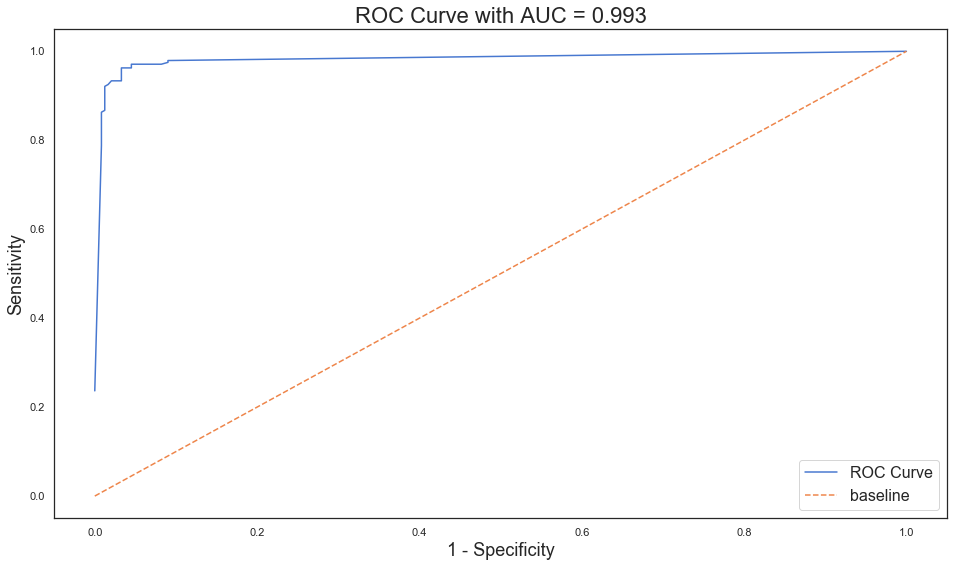

In [112]:
# Creating the area under ROC
plt.figure(figsize = (16,9))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

With an ROC AU of 0.993, the model is able to sperate the positive (askscience) and negative (askhistorians) with a high degree of certainty.

## Holdout

In [113]:
predict_holdout = gs2.predict(holdout_text)

In [114]:
gs2.score(holdout_text, holdout_y)

0.94

In [115]:
confusion_matrix(predict_holdout, holdout_y)

array([[117,   7],
       [  8, 118]], dtype=int64)

In [116]:
tn, fp, fn, tp = confusion_matrix(predict_holdout, holdout_y).ravel()

In [117]:
#Equal proportion of misclassification on both sides
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 117
False Positives: 7
False Negatives: 8
True Positives: 118


In [118]:
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)

print('Precision of gs1 using holdout data is: %s' % round(Precision,2))
print('Sensitivity of gs1 using holdout data is: %s' % round(Sensitivity,2))

Precision of gs1 using holdout data is: 0.94
Sensitivity of gs1 using holdout data is: 0.94


### Misclassified

In [119]:
predict_holdout

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [126]:
holdout_df['predicted'] = predict_holdout

In [132]:
holdout_df[holdout_df['subreddit'] != holdout_df['predicted']]

,subreddit,text,predicted
9,1,What Information was Available via Tests and R...,0
20,1,"Question about Abraham Maslow's ""Toward a psyc...",0
28,1,What were homo sapiens original diets?,0
61,1,Was there a way to discover twins in a pregnan...,0
95,1,Why did it take humans so long to discover agr...,0
104,1,Why is Australia so rich with mineral deposits...,0
113,1,Why must Venturi respirator valves be replaced...,0
137,0,What am I doing wrong? I never seem to see que...,1
163,0,What does the scholarship say about the transi...,1
173,0,"""Natural gut"" tennis strings, made out of shee...",1


More data can be gathered to help reduce misclassification on both positive and negative classes

### Distribution

The two histograms show the probability of outcome for the two different classes. As seen, the two classes are very distinct given the concentration at P=0 and P=1.

In [120]:
#creating a dataframe that holds true values of the test set
# as well as the predicted probabilty

holdout_pred_proba = [i[1] for i in gs1.predict_proba(holdout_text)]

holdout_pred_df = pd.DataFrame({'true_values': holdout_y,
                        'pred_probs':holdout_pred_proba})

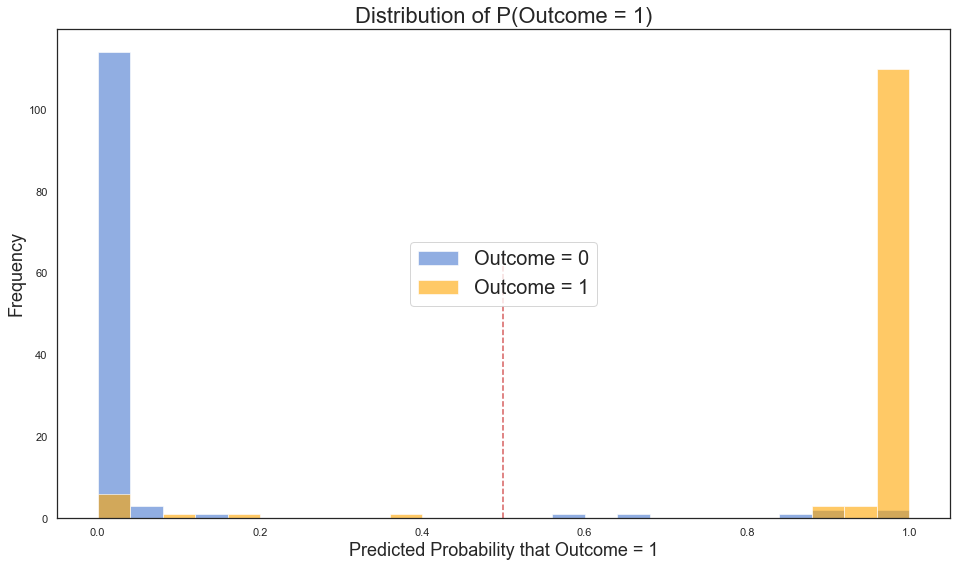

In [121]:
# Create figure.
plt.figure(figsize = (16,9))

# Create two histograms of observations.
plt.hist(holdout_pred_df[holdout_pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(holdout_pred_df[holdout_pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')


# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20, loc='center');

### ROC AU

The ROC AU is a metric that scores how well a model is able to distinguish between classes. In this case, an ROC AU of 0.977 shows that the model is able to distinguish askscience and askhistorians. A score of 1 would mean that the model is perfectly able to seperate askscience from askhistorians. While a score of 0.5 would mean that the model is unable to tell askscience from askhistorians.

In [122]:
# Calculate ROC AUC.
roc_auc_score(holdout_pred_df['true_values'], holdout_pred_df['pred_probs'])

0.97856

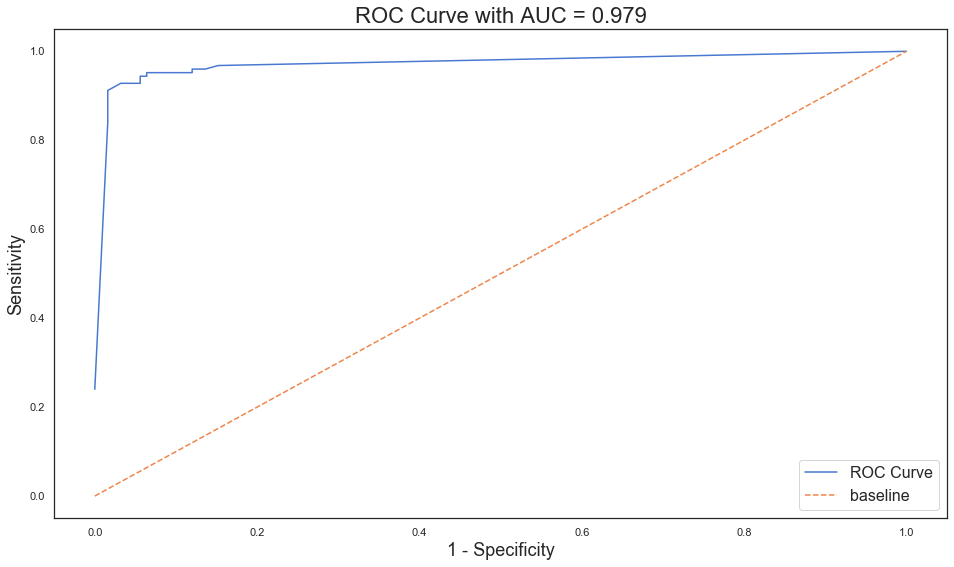

In [123]:
# Create figure.
plt.figure(figsize = (16,9))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(holdout_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(holdout_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(holdout_pred_df["true_values"], holdout_pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## Conclusion


The best model to use to differentiate the two subreddits is gs2, **TfidfVectorizer into Naive Bayes**. The best hyperparameters:
- 'nb__alpha': 1,
- 'tfid__max_df': 0.85,
- 'tfid__max_features': 4000,
- 'tfid__min_df': 2,
- 'tfid__ngram_range': (1, 1)




It manages to outperform the other models across all metrics as well as the baseline (score of 0.496):


|Model|Accuracy Score on train|Accuracy Score on test|Precision|Sensitivity|
|---|---|---|---|---|
|**gs1** CountVectorizer->Naive Bayes|0.990|0.955|0.94|0.97|
|**gs2** TfidfVectorizer->Naive Bayes|0.991|0.961|0.95|0.97|
|**gs3** CountVectorizer->Support Vector Machines|1.000|0.915|0.89|0.93|
|**gs4** TfidfVectorizer->Support Vector Machines|0.998|0.940|0.93|0.95|
|---|---|---|---|---|
|**gs2 on holdout**|---|**0.94**|**0.94**|**0.94**|


On unseen data, the gs2 model has an **accuracy score of 0.94**, **precision of 0.94** and **sensitivity of 0.94** and an **ROC AU of 0.977**. We can conclude that it will be able to differentiate between the two subreddits, askscience and askhistorians inorder for us to find out more questions the general public has on science topics. This will help us with our goal of increasing book sales and online viewership.

### Further improvements to the model

- Improvements can be made my increasing the number of data points. As reddit limits the API webscrape to 1000, our training set is limited to 1453 posts. Having scrapped more will result in lower variance and less overfitting.
- Further tune my gridsearch to reduce hyperparamters
- Other models could be used for comparison as well, logistic regression, random forest classifiers etc.
- Use an ensemble of models to reduce overfitting.
- As all four models have high accuracy, precision and sensitivity score, it leads me to conclude that the datasets of askscience vs ask historians are quite different despite them being both an 'ask expert' subreddit. The model could be tested on a dataset that is more similar in order to ascertain how effective the model is at subreddit classification. 
